In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
from pylab import rcParams
import statsmodels.api as sm
import statistics
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

In [4]:
df = pd.read_csv(r'C:\Users\dre2\Desktop\personal docs\WGU\D208\churn_clean.csv')

<h2>Drop columns we dont need, look for nulls/replace as needed.</h2>

In [5]:
df = df.drop(columns=['City', 'State', 'County', 'Zip', 'Lat', 'Lng', 
                      'Population', 'Area', 'TimeZone', 'Job', 'Marital', 'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure', 'Techie', 'Contract', 'Port_modem', 'Tablet', 
                      'InternetService', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 
                      'Tenure', 'MonthlyCharge', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8', 'PaymentMethod'])
nulls = df.isnull().any()
print(nulls)

CaseOrder            False
Customer_id          False
Interaction          False
UID                  False
Children             False
Age                  False
Income               False
Gender               False
Churn                False
Bandwidth_GB_Year    False
dtype: bool


<h2>Check z-scores for x-vars and drop if > |3|.</h2>

In [6]:
#Check z-scores for x-vars and drop if > |3|.
childrenZ = df.loc[ : , 'Children']
df['childrenZ'] = stats.zscore(childrenZ)

ageZ = df.loc[ : , 'Age']
df['ageZ'] = stats.zscore(ageZ)

incomeZ = df.loc[ : , 'Income']
df['incomeZ'] = stats.zscore(incomeZ)

#change data type from float to int64
df['childrenZ'] = df['childrenZ'].astype(np.int64)
df['ageZ'] = df['ageZ'].astype(np.int64)
df['incomeZ'] = df['incomeZ'].astype(np.int64)

#drop if > |3|
df.drop(df[df['childrenZ'] > 3].index, inplace = True)
df.drop(df[df['childrenZ'] < -3].index, inplace = True)
df.drop(df[df['ageZ'] > 3].index, inplace = True)
df.drop(df[df['ageZ'] < -3].index, inplace = True)
df.drop(df[df['incomeZ'] > 3].index, inplace = True)
df.drop(df[df['incomeZ'] < -3].index, inplace = True)

#delete z-score columns
df = df.drop(columns=['childrenZ', 'ageZ', 'incomeZ'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9960 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CaseOrder          9960 non-null   int64  
 1   Customer_id        9960 non-null   object 
 2   Interaction        9960 non-null   object 
 3   UID                9960 non-null   object 
 4   Children           9960 non-null   int64  
 5   Age                9960 non-null   int64  
 6   Income             9960 non-null   float64
 7   Gender             9960 non-null   object 
 8   Churn              9960 non-null   object 
 9   Bandwidth_GB_Year  9960 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 855.9+ KB


In [7]:
#Change data type of Bandwidth_GB_Year and Income to int64
df['Income'] = df['Income'].astype(np.int64)
df['Bandwidth_GB_Year'] = df['Bandwidth_GB_Year'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9960 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CaseOrder          9960 non-null   int64 
 1   Customer_id        9960 non-null   object
 2   Interaction        9960 non-null   object
 3   UID                9960 non-null   object
 4   Children           9960 non-null   int64 
 5   Age                9960 non-null   int64 
 6   Income             9960 non-null   int64 
 7   Gender             9960 non-null   object
 8   Churn              9960 non-null   object
 9   Bandwidth_GB_Year  9960 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 855.9+ KB


In [8]:
#summary statistics of cleaned df
df.describe()

,CaseOrder,Children,Age,Income,Bandwidth_GB_Year
count,9960.000000,9960.000000,9960.000000,9960.000000,9960.000000
mean,5001.381426,2.088454,53.097892,39261.710241,3391.961345
std,2886.590495,2.147374,20.701925,26860.824875,2185.211493
min,1.000000,0.000000,18.000000,348.000000,155.000000
25%,2500.750000,0.000000,35.000000,19166.500000,1236.000000
50%,5001.500000,1.000000,53.000000,33028.000000,3287.000000
75%,7501.250000,3.000000,71.000000,52921.250000,5585.250000
max,10000.000000,10.000000,89.000000,152172.000000,7158.000000


In [9]:
df['Gender'].value_counts()

Gender
Female       5006
Male         4725
Nonbinary     229
Name: count, dtype: int64

In [10]:
df['Churn'].value_counts()

Churn
No     7326
Yes    2634
Name: count, dtype: int64

In [11]:
df['gender_dummy'] = [1 if v == 'Female' else 0 for v in df['Gender']]
df['churn_dummy'] = [1 if v == 'Yes' else 0 for v in df['Churn']]

df['intercept'] = 1
model = sm.OLS(df['Bandwidth_GB_Year'], df[['gender_dummy', 'churn_dummy','Children', 'Age', 'Income', 'intercept']]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     485.7
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:39:57   Log-Likelihood:                -89632.
No. Observations:                9960   AIC:                         1.793e+05
Df Residuals:                    9954   BIC:                         1.793e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
gender_dummy   -59.9693     39.301     -1.526   

In [12]:
df['intercept'] = 1
reduced_model = sm.OLS(df['Bandwidth_GB_Year'], df[['churn_dummy','Children', 'intercept']]).fit()
print(reduced_model.summary())

                            OLS Regression Results                            
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     1212.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:39:57   Log-Likelihood:                -89634.
No. Observations:                9960   AIC:                         1.793e+05
Df Residuals:                    9957   BIC:                         1.793e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
churn_dummy -2188.4209     44.526    -49.150      

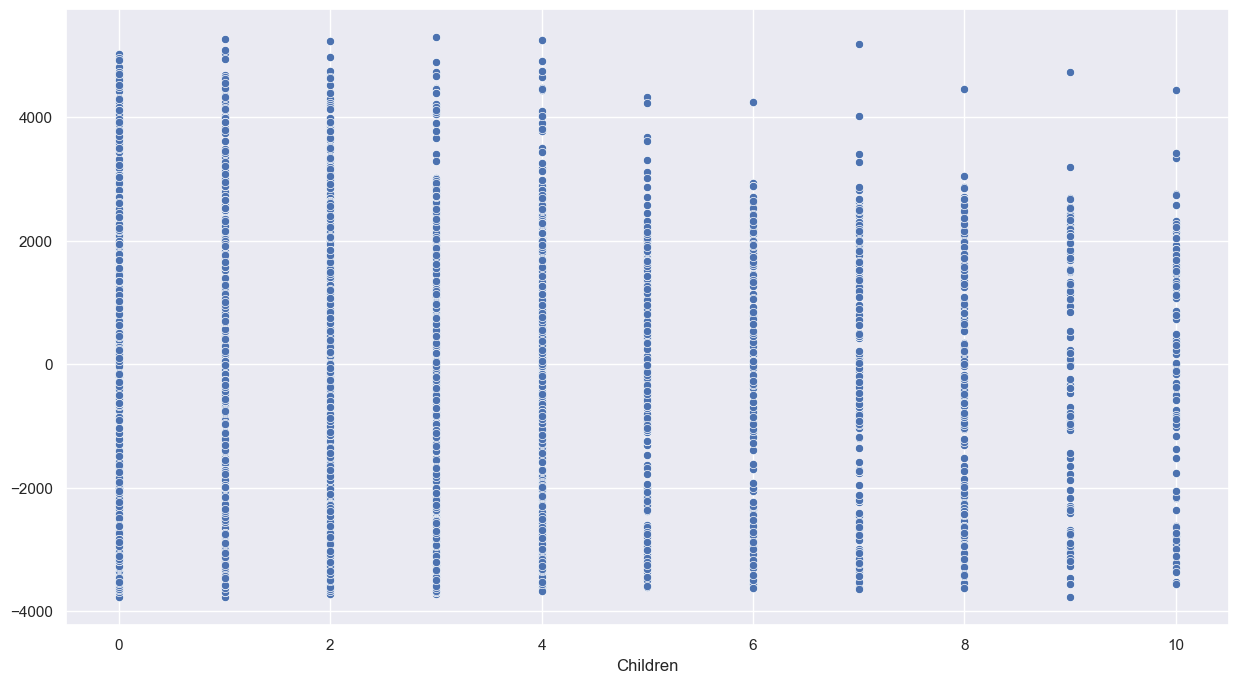

In [13]:
df['intercept'] = 1
residuals = df['Bandwidth_GB_Year'] - reduced_model.predict(df[['churn_dummy', 'Children', 'intercept']])
sns.scatterplot(x=df['Children'],y=residuals)
plt.show();